# Spotipy
First we import the spotipy library to easily interface with the Spotify API, and <b>get the saved tracks</b>

In [37]:
import spotipy
from spotipy.oauth2 import SpotifyOAuth
client_id = 'your_client_id'
client_secret = 'your_client_secret'
sp = spotipy.Spotify(auth_manager=SpotifyOAuth(client_id=client_id,
                                                           client_secret=client_secret,
                                                           redirect_uri="http://localhost:8888/callback",
                                                           scope="user-library-read"))
offset = 0
#get all saved tracks from spotify changing offset to get all tracks
numSongs=150
track_features = []
while True:
    results=sp.current_user_saved_tracks(limit=50,offset=offset)
    for item in results['items']:
        track = item['track']
        track_features.append(sp.audio_features(track['id']))
    offset+=50
    if offset+50>=numSongs:
        break


## Removed columns
- track links, IDs and similar metadata.
- Speechiness is redundant since we already have acousticness, and we also don't care about non-musical content (i.e. podcasts or audiobooks).
- Key is not useful since I don't have perfect pitch.
- Liveness since I don't really care if a song was recorded live or in studio (most of them are in studio anyway).
- Mode is reduntant since we have Valence, that best portrays the mood of the song (and the mode distribution is almost equiprobable).
- duration_ms is irrelevant since the vast majority of songs is in the 3-5 minutes range (and I really don't care about it)

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

#convert all the features into a dataframe, NOT JUST THE FIRST
df=[]
for i in range(len(track_features)):
    df.append(pd.DataFrame(track_features[i]))
df = pd.concat(df)
df.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
df['like']=1

In [39]:
df.head()

,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,like
0,0.484,0.470,-13.111,0.580,0.07510,0.188,107.794,1
0,0.697,0.612,-7.692,0.426,0.00000,0.606,97.805,1
0,0.469,0.672,-9.230,0.202,0.00000,0.682,99.471,1
0,0.711,0.852,-6.366,0.873,0.00000,0.724,89.531,1
0,0.722,0.596,-10.022,0.174,0.00006,0.509,95.056,1


array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'like'}>, <AxesSubplot: >]],
      dtype=object)

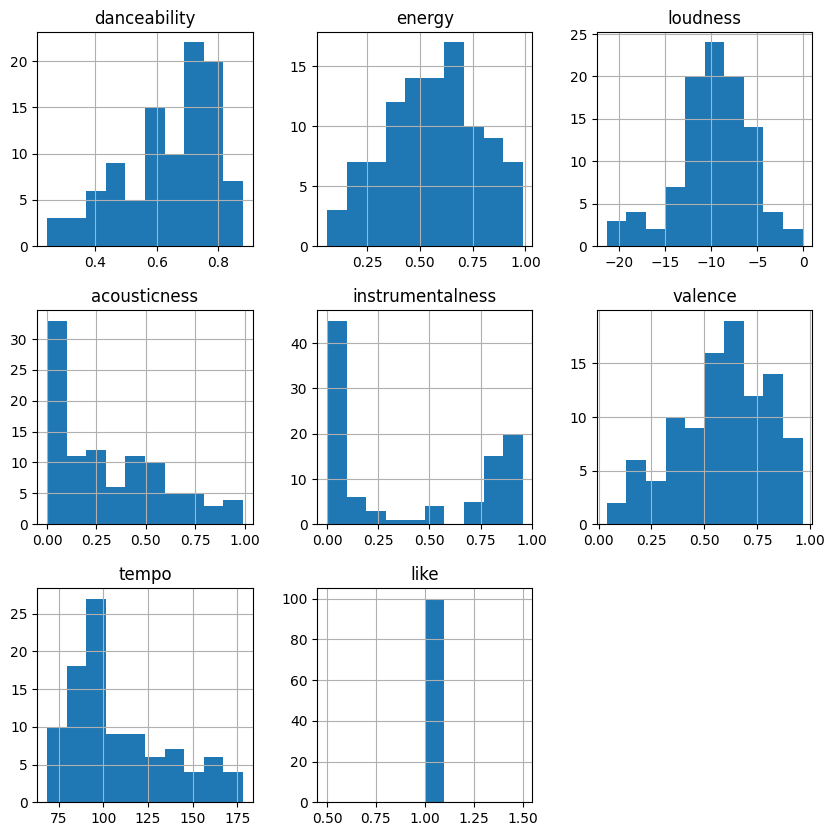

In [40]:
df.hist(figsize=(10,10))

By using correlation values and reasoning, i can create a custom model for the Bayesian network

<AxesSubplot: >

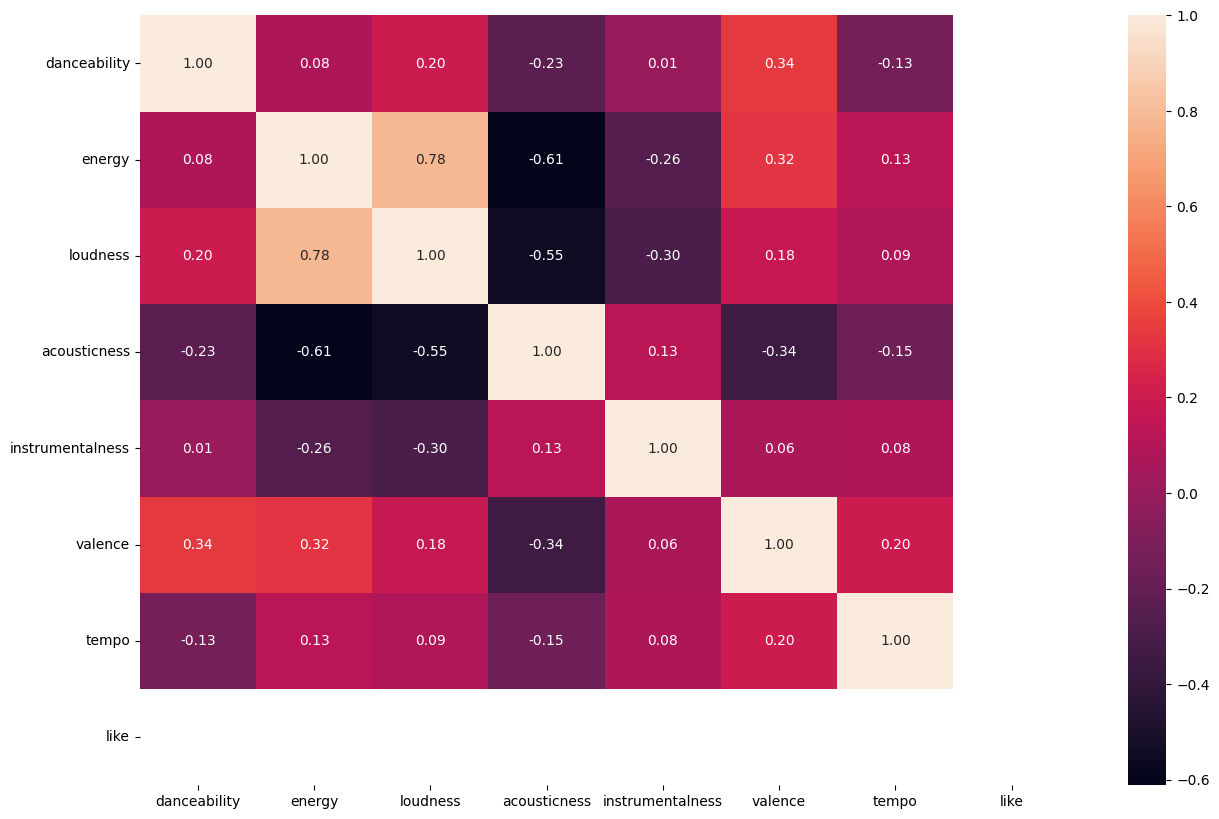

In [41]:
#show correlation between features
fig= plt.figure(figsize=(15,10))
corr = df.corr()
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            annot=True, fmt=".2f")
            

In [43]:
top50=[]

#get top 50 songs in US, IT and UK
markets=['US', 'IT', 'UK']
for market in markets:
    results = sp.search(q='year:2022', type='track', limit=50, offset=0, market='US')
    #get features
    for i in range(len(results['tracks']['items'])):
        top50.append(sp.audio_features(results['tracks']['items'][i]['id']))
#convert to dataframe
dfTop50=[]
for i in range(len(top50)):
    dfTop50.append(pd.DataFrame(top50[i]))
dfTop50 = pd.concat(dfTop50)
dfTop50.drop(['type','id','uri','track_href','analysis_url','time_signature', 'key', 'mode', 'speechiness', 'liveness', 'duration_ms'],axis=1,inplace=True)
#add column named 'like' with all 0s
dfTop50['like']=0
dfTop50.head()


,danceability,energy,loudness,acousticness,instrumentalness,valence,tempo,like
0,0.686,0.507,-7.097,0.6260,0.000075,0.690,168.955,0
0,0.780,0.689,-5.668,0.0368,0.000010,0.642,115.042,0
0,0.561,0.520,-9.342,0.0503,0.000002,0.424,153.150,0
0,0.714,0.472,-7.375,0.0130,0.000005,0.238,131.121,0
0,0.637,0.643,-6.571,0.1300,0.000002,0.533,97.008,0


array([[<AxesSubplot: title={'center': 'danceability'}>,
        <AxesSubplot: title={'center': 'energy'}>,
        <AxesSubplot: title={'center': 'loudness'}>],
       [<AxesSubplot: title={'center': 'acousticness'}>,
        <AxesSubplot: title={'center': 'instrumentalness'}>,
        <AxesSubplot: title={'center': 'valence'}>],
       [<AxesSubplot: title={'center': 'tempo'}>,
        <AxesSubplot: title={'center': 'like'}>, <AxesSubplot: >]],
      dtype=object)

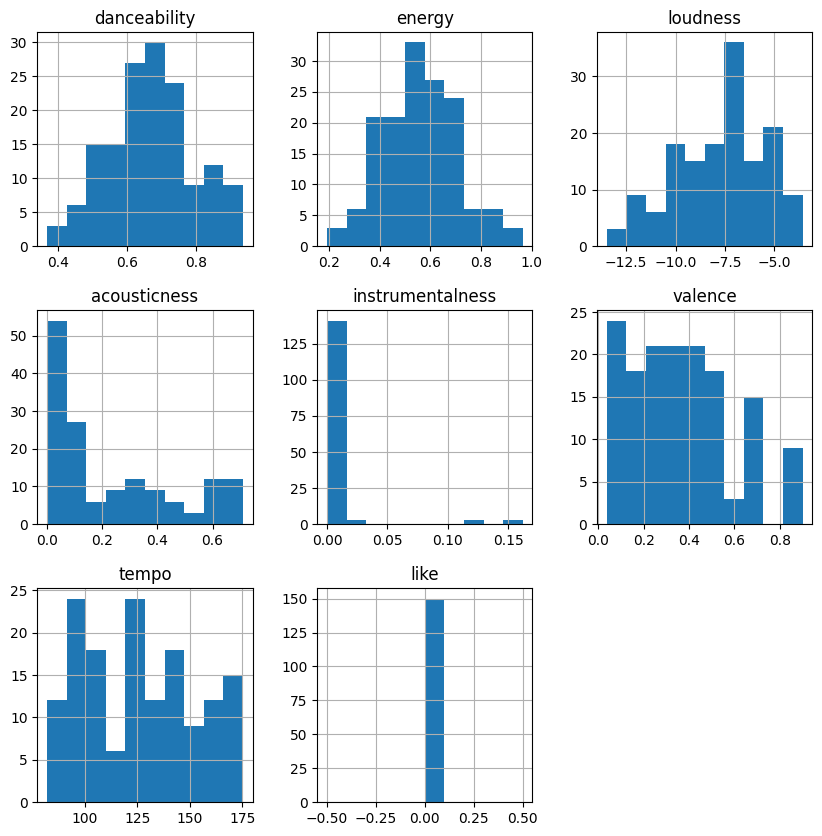

In [44]:
dfTop50.hist(figsize=(10,10))

<AxesSubplot: >

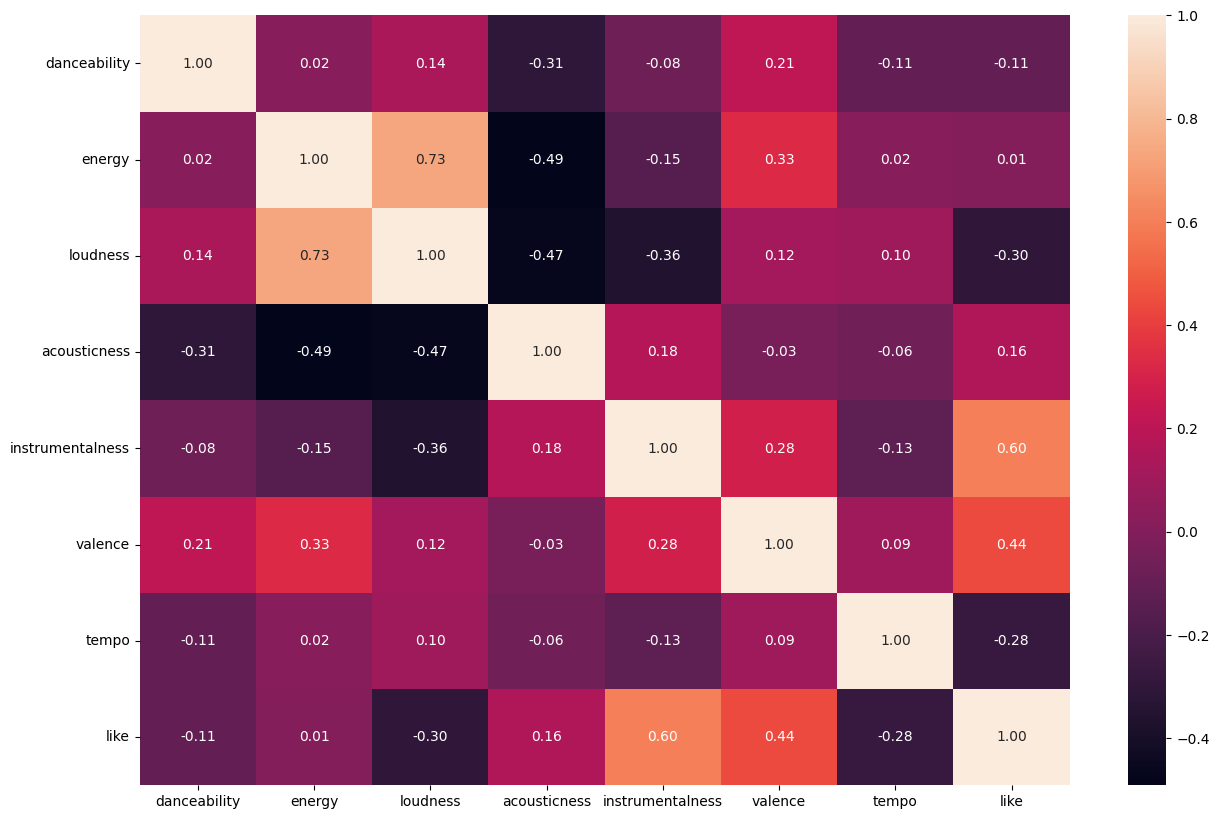

In [46]:
dfUnified=pd.concat([df,dfTop50])
fig= plt.figure(figsize=(15,10))
sns.heatmap(dfUnified.corr(),annot=True, fmt=".2f")

Save data in CSV file

In [47]:
dfUnified.to_csv('spotifyData.csv')

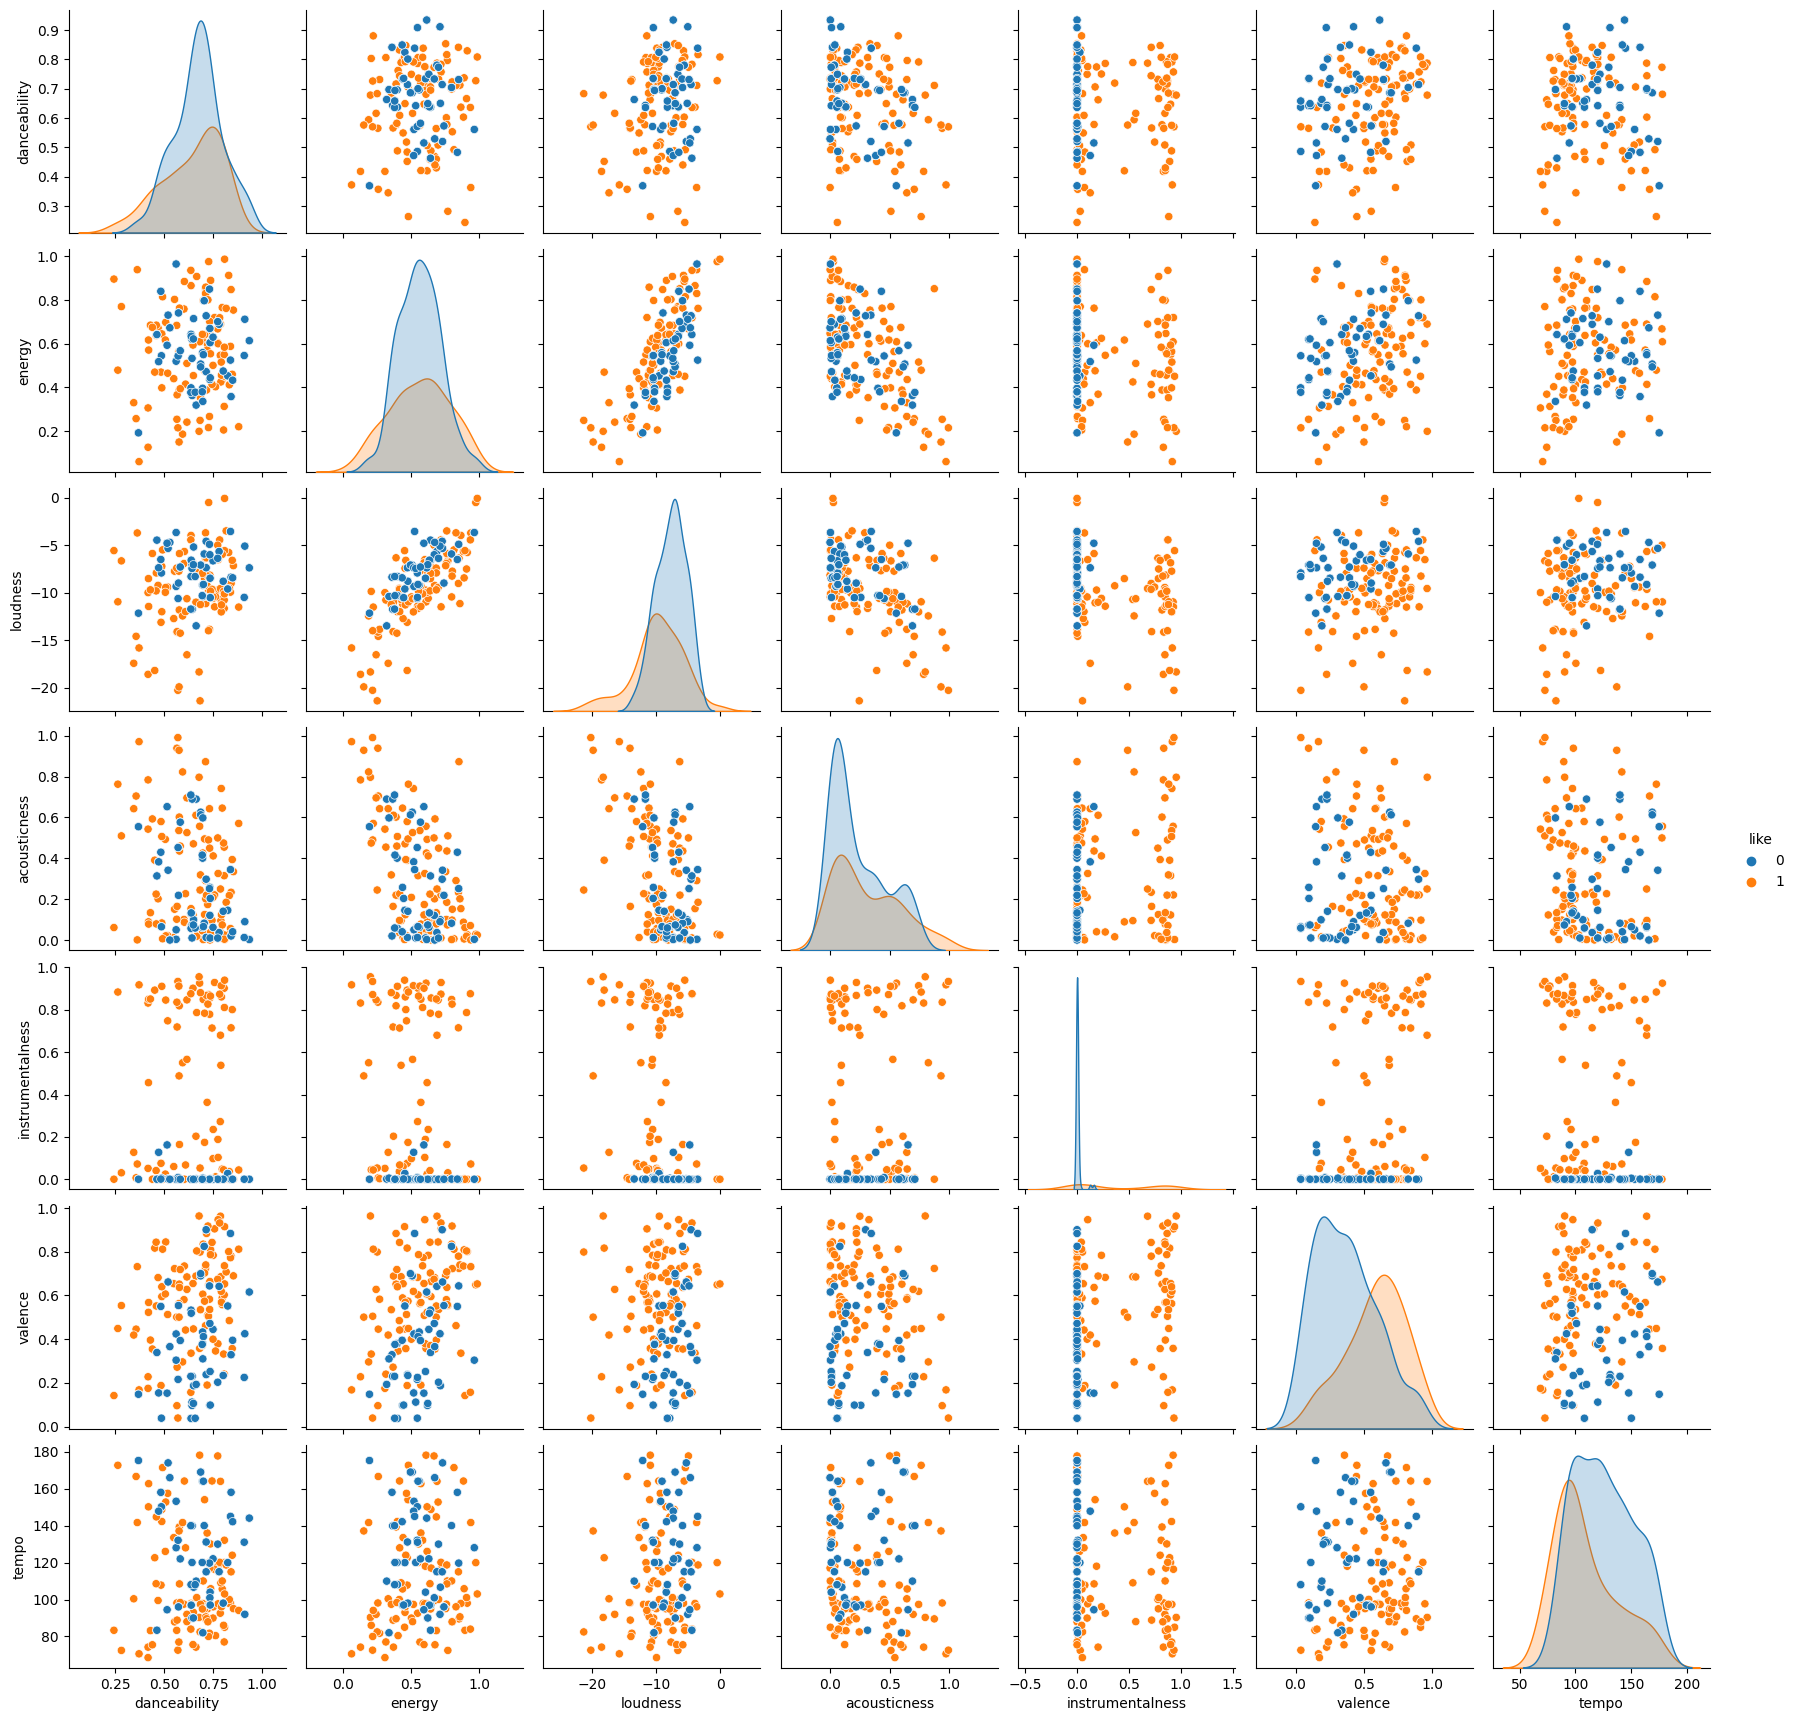

In [48]:
#pairplot
sns.pairplot(dfUnified, hue='like')

# References
- Spotify API documentation: https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features 
- Similar project on Kaggle (but not with Bayesian networks): 